# Property analysis

TODO: work-in-progress

### Required dependencies

In [3]:
# Standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings("ignore")
from statsmodels.graphics.factorplots import interaction_plot

# Installed packages
%pip install seaborn
import seaborn as sns
%pip install statsmodels
import statsmodels.api as sm
%pip install pingouin
import pingouin as pg

# Local packages
# NOTE: avoid having to use a local module to ease use of google colab

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


### Dataset to use

In [4]:
dtype = {
    'statusType': 'string',
    'statusText': 'string',
    'imgSrc': 'string',
    'detailUrl': 'string',
    'currency': 'string',
    'country': 'string',
    'city': 'string',
    'state': 'string',
    'unformattedPrice': 'float64',
    'addressStreet': 'string',
    'addressCity': 'string',
    'addressState': 'string',
    'addressZipcode': 'string',
    'bedrooms': 'float64',
    'bathrooms': 'float64',
    'livingArea': 'float64',
    'latitude': 'float64',
    'longitude': 'float64',
    'homeType': 'string',
    'lotAreaValue': 'float64',
    'lotAreaUnit': 'string',
    'zestimate': 'float64',
    'rentZestimate': 'float64',
    'isNonOwnerOccupied': 'boolean',
    'isPremierBuilder': 'boolean',
    'taxAssessedValue': 'float64',
    'brokerName': 'string',
    'isZillowOwned': 'boolean',
    'livingAreaUnit': 'string',
}
df: pd.DataFrame = pd.read_csv('./content/properties-2023-abr-07.csv', dtype=dtype)
df.describe()

,unformattedPrice,bedrooms,bathrooms,livingArea,latitude,longitude,lotAreaValue,zestimate,rentZestimate,taxAssessedValue
count,1.161960e+05,86810.000000,86743.000000,8.399900e+04,98501.000000,98501.000000,96903.000000,4.717700e+04,66577.000000,6.728900e+04
mean,5.359327e+05,3.483873,2.558401,2.488193e+03,38.008534,-96.421389,2634.237308,5.542392e+05,2610.983237,2.953694e+05
std,2.525859e+06,45.635180,8.859761,2.695677e+04,5.478280,14.904569,3908.956107,1.046013e+06,4989.668836,1.578925e+06
min,1.000000e+00,1.000000,0.500000,1.000000e+00,24.547697,-124.520210,0.010000,1.040000e+04,86.000000,1.000000e+00
25%,1.599000e+05,3.000000,2.000000,1.377000e+03,33.770256,-108.610570,0.750000,2.290810e+05,1400.000000,7.990000e+04
50%,3.290000e+05,3.000000,2.000000,1.839000e+03,38.591150,-94.909850,10.000000,3.649020e+05,1949.000000,1.832000e+05
75%,5.490000e+05,4.000000,3.000000,2.501000e+03,42.662160,-83.944954,6067.454000,5.791440e+05,2700.000000,3.327000e+05
max,7.120000e+08,13443.000000,2011.000000,5.252862e+06,47.205753,-67.896580,361548.000000,7.742917e+07,506264.000000,3.294410e+08


### Removing not needed columns

In [5]:
# These columns are not relevant for the analysis
columns_to_drop = [
    'imgSrc', 'detailUrl', 'zestimate', 'brokerName',
    'rentZestimate', 'isZillowOwned', 'isNonOwnerOccupied',
    'latitude', 'longitude',
]
df = df.drop(columns=columns_to_drop)
print(f"columns:\t{', '.join(df.columns)}")

columns:	statusType, statusText, currency, country, city, state, unformattedPrice, addressStreet, addressCity, addressState, addressZipcode, bedrooms, bathrooms, livingArea, homeType, lotAreaValue, lotAreaUnit, isPremierBuilder, taxAssessedValue, livingAreaUnit


### Removing duplicates properties

In [6]:
# Removing duplicated properties

class Diff:
    """Calculate difference between two stages?"""

    def __init__(self) -> None:
        self.starting = None

    def start(self, value: float) -> None:
        """Set starting value"""
        self.starting = value

    def stop(self, value: float) -> tuple:
        """Calculate absolute difference between starting and
           stopping value, calculate percent difference"""
        if self.starting is None:
            raise ValueError('Starting value is not set.')
        diff = value - self.starting
        perc = percent(self.starting, diff)
        return abs(diff), perc

def percent(total: float, part: float) -> float:
    """Calculate percent of part to total"""
    return round((part / total) * 100, 3)

diff: Diff = Diff()
diff.start(len(df.index))

df = df.drop_duplicates(subset=['addressStreet'])

# Show results
removed, perc = diff.stop(len(df.index))
print(f'Removed {removed} of {diff.starting} rows ({perc}%) with same address street.')

Removed 783 of 116468 rows (-0.672%) with same address street.


### Treating missing values

In [7]:
# Removing Nan values
diff.start(len(df.index))

# Remember that this dataset was scraped from a website and the
# non existent of these values equals to a 'false', '0' or 'empty',
# that is why we dont apply some strategy to fill the NaNs.
df['isPremierBuilder'] = df['isPremierBuilder'].replace(np.nan, False)

# Removing rows with NaNs
for column in df.columns:
    df = df[df[column].notna()]

# Show results
removed, perc = diff.stop(len(df.index))
nan_remain = df.isna().sum().sum()
print(f'Removed {removed} of {diff.starting} rows ({perc}%), {nan_remain} Nan values remain.')


Removed 63464 of 115685 rows (-54.859%), 0 Nan values remain.


### Standardization of units

In [8]:
def show_unique_categories(column) -> None:
    categories = df[column].unique()
    print(f"{column}:\t{', '.join(categories)}\t({len(categories)})")

def show_units() -> None:
    print('Current units used in the dataset:')
    show_unique_categories('currency')
    show_unique_categories('livingAreaUnit')
    show_unique_categories('lotAreaUnit')

show_units()

Current units used in the dataset:
currency:	USD	(1)
livingAreaUnit:	sqft	(1)
lotAreaUnit:	sqft, acres	(2)


In [9]:
# Convert

def acre_to_sqft(acre: float) -> float:
    """Convert acre to square feet"""
    return acre * 43560

def sqft_to_acre(sqft: float) -> float:
    """Convert square feet to acre"""
    return sqft / 43560

df.loc[df['lotAreaUnit'] == 'acres', 'lotAreaValue'] = acre_to_sqft(df['lotAreaValue'])
df.loc[df['lotAreaUnit'] == 'acres', 'lotAreaUnit'] = 'sqft'

In [10]:
# Check if the conversion was successful
show_units()

Current units used in the dataset:
currency:	USD	(1)
livingAreaUnit:	sqft	(1)
lotAreaUnit:	sqft	(1)


### Adding new relations

In [11]:
# Relation between price and lot area
df['pricePerLotArea'] = df['unformattedPrice'] / df['livingArea']

# Relation between price and living area
df['pricePerLivingArea'] = df['unformattedPrice'] / df['lotAreaValue']

df.head()

,statusType,statusText,currency,country,city,state,unformattedPrice,addressStreet,addressCity,addressState,...,bathrooms,livingArea,homeType,lotAreaValue,lotAreaUnit,isPremierBuilder,taxAssessedValue,livingAreaUnit,pricePerLotArea,pricePerLivingArea
0,FOR_SALE,House for sale,USD,USA,Marathon,FL,622000.0,11329 5th Ave,Marathon,FL,...,1.0,793.0,SINGLE_FAMILY,3049.2,sqft,False,343856.0,sqft,784.363178,203.987931
3,FOR_SALE,New construction,USD,USA,Islamorada,FL,4200000.0,85331 Overseas Hwy,Islamorada,FL,...,3.0,2880.0,SINGLE_FAMILY,13300.0,sqft,False,350195.0,sqft,1458.333333,315.789474
4,FOR_SALE,New construction,USD,USA,Islamorada,FL,4400000.0,85327 Overseas Hwy,Islamorada,FL,...,3.0,2880.0,SINGLE_FAMILY,13300.0,sqft,False,350195.0,sqft,1527.777778,330.827068
5,FOR_SALE,House for sale,USD,USA,Cudjoe Key,FL,799000.0,22973 Anne Bonny Ln,Cudjoe Key,FL,...,2.0,992.0,SINGLE_FAMILY,6188.0,sqft,False,420487.0,sqft,805.443548,129.120879
6,FOR_SALE,House for sale,USD,USA,Key West,FL,1149000.0,3532 Duck Ave,Key West,FL,...,2.0,1528.0,SINGLE_FAMILY,6600.0,sqft,False,508800.0,sqft,751.963351,174.090909


### Removing outliers

In [12]:
# Removing outliers
diff.start(len(df.index))

def cut_between(column: str, min: float, max: float) -> None:
    global df # this fixes referenced before assignment
    df = df[(df[column] > min) & (df[column] < max)]

cut_between('unformattedPrice', 1000, 1250000)
cut_between('livingArea', 100, 5000)
cut_between('lotAreaValue', 100, 4000000)
cut_between('bedrooms', 0, 10)
cut_between('bathrooms', 0, 10)
cut_between('taxAssessedValue', 1000, 800000)
cut_between('pricePerLotArea', 0, 1500)
cut_between('pricePerLivingArea', 0, 500)

def filter_with_zscore(column: str, threshold: float) -> None:
    global df # this fixes referenced before assignment
    z = np.abs(stats.zscore(df[column]))
    df = df[(z < threshold)]

## filter_with_zscore('unformattedPrice', 3)
## filter_with_zscore('livingArea', 3)
## filter_with_zscore('lotAreaValue', 3)
## filter_with_zscore('bedrooms', 3)
## filter_with_zscore('bathrooms', 3)
## filter_with_zscore('taxAssessedValue', 3)
## filter_with_zscore('pricePerLotArea', 3)
## filter_with_zscore('pricePerLivingArea', 3)

# Show results
removed, perc = diff.stop(len(df.index))
print(f'Removed {removed} of {diff.starting} rows ({perc}%) with outliers.')
numeric_columns = df.select_dtypes(include=np.number).columns
df[numeric_columns].describe()

Removed 5629 of 52221 rows (-10.779%) with outliers.


,unformattedPrice,bedrooms,bathrooms,livingArea,lotAreaValue,taxAssessedValue,pricePerLotArea,pricePerLivingArea
count,4.659200e+04,46592.000000,46592.000000,46592.000000,4.659200e+04,46592.000000,46592.000000,46592.000000
mean,3.868187e+05,3.289234,2.327131,1952.411530,6.350776e+04,222813.768394,205.581023,42.639253
std,2.314118e+05,0.950631,0.896626,813.482605,2.383039e+05,159881.705297,120.888860,55.471666
min,1.234000e+03,1.000000,1.000000,140.000000,2.918520e+02,1048.000000,0.736277,0.005032
25%,2.190000e+05,3.000000,2.000000,1353.000000,6.969600e+03,97350.000000,130.560844,10.559199
50%,3.450000e+05,3.000000,2.000000,1798.000000,1.045440e+04,189831.000000,181.550103,26.812567
75%,5.000000e+05,4.000000,3.000000,2395.000000,2.352240e+04,312200.000000,250.757699,52.453800
max,1.249999e+06,9.000000,8.000000,4998.000000,3.950892e+06,799812.000000,1480.246914,499.311295


### Exploratory analysis the dataset

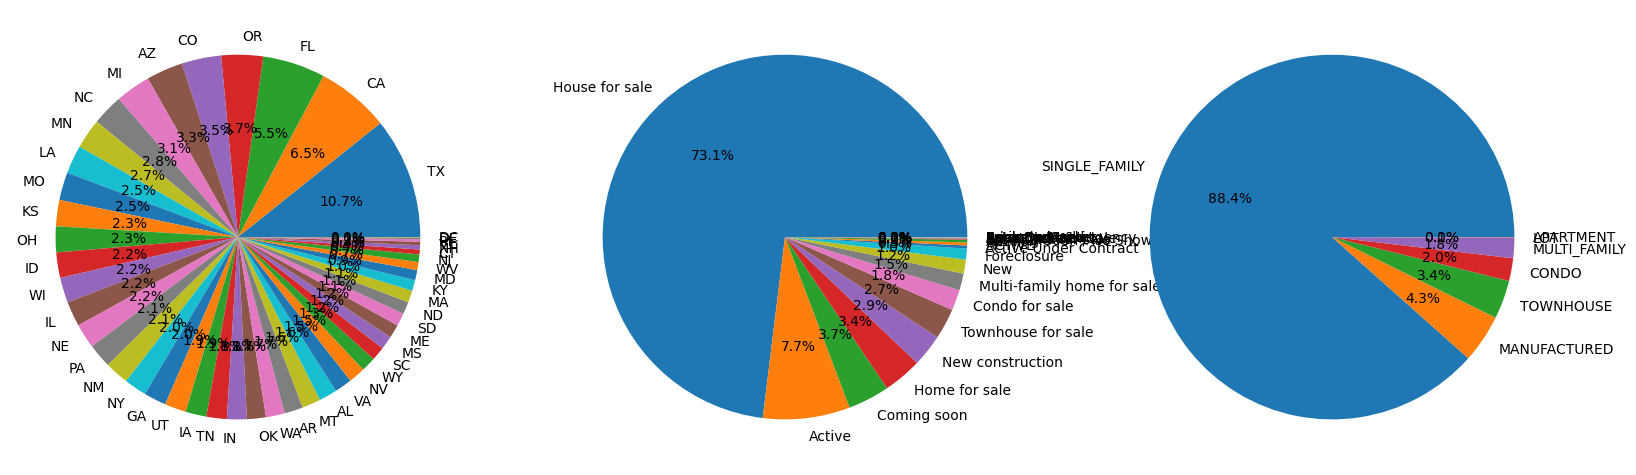

In [13]:
# Plotting states, status and home types
fig, axs = plt.subplots(1, 3, figsize=(20, 20))
df.state.value_counts(normalize=True).plot.pie(autopct='%1.1f%%', ylabel='', ax=axs[0])
df.statusText.value_counts(normalize=True).plot.pie(autopct='%1.1f%%', ylabel='', ax=axs[1])
df.homeType.value_counts(normalize=True).plot.pie(autopct='%1.1f%%', ylabel='', ax=axs[2])
plt.show()

In [14]:
# We will only keep with properties that are "single family" and "house for sale"
# for now due its majority and we can get more correlations due to similar characteristics.
diff.start(len(df.index))
df = df.loc[df['homeType'] == 'SINGLE_FAMILY']
df = df.loc[df['statusText'] == 'House for sale']
filtered, perc = diff.stop(len(df.index))
print(f'Filtered {filtered} of {diff.starting} rows ({perc}%) with home type and status.')

Filtered 12555 of 46592 rows (-26.947%) with home type and status.


Text(0.5, 0.98, 'Distribution of numerical variables')

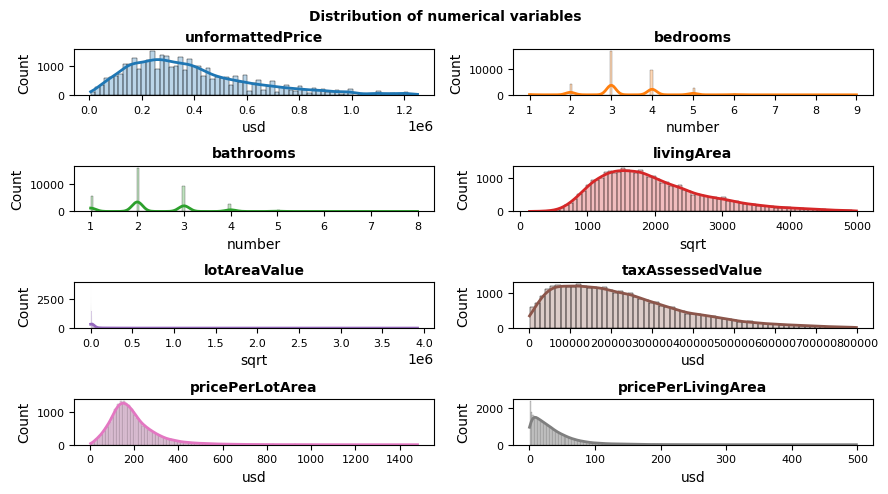

In [15]:
# Select columns to plot
numeric_columns = df.select_dtypes(include=['float64', 'int']).columns

# Plotting
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(9, 5))
axes = axes.flat
for i, column in enumerate(numeric_columns):
    sns.histplot(
        data = df,
        x = column,
        stat = "count",
        kde = True,
        color = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        line_kws = {'linewidth': 2},
        alpha = 0.3,
        ax = axes[i],
    )
    axes[i].set_title(column, fontsize = 10, fontweight = "bold")
    axes[i].tick_params(labelsize = 8)
    ## TODO: replace hardcoded xlabels
    xlabel = 'number'
    xlabel = 'sqrt' if 'area' in df[column].name.lower() else xlabel
    xlabel = 'usd' if 'price' in df[column].name.lower() else xlabel
    xlabel = 'usd' if 'tax' in df[column].name.lower() else xlabel
    axes[i].set_xlabel(xlabel)
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Distribution of numerical variables', fontsize = 10, fontweight = "bold")

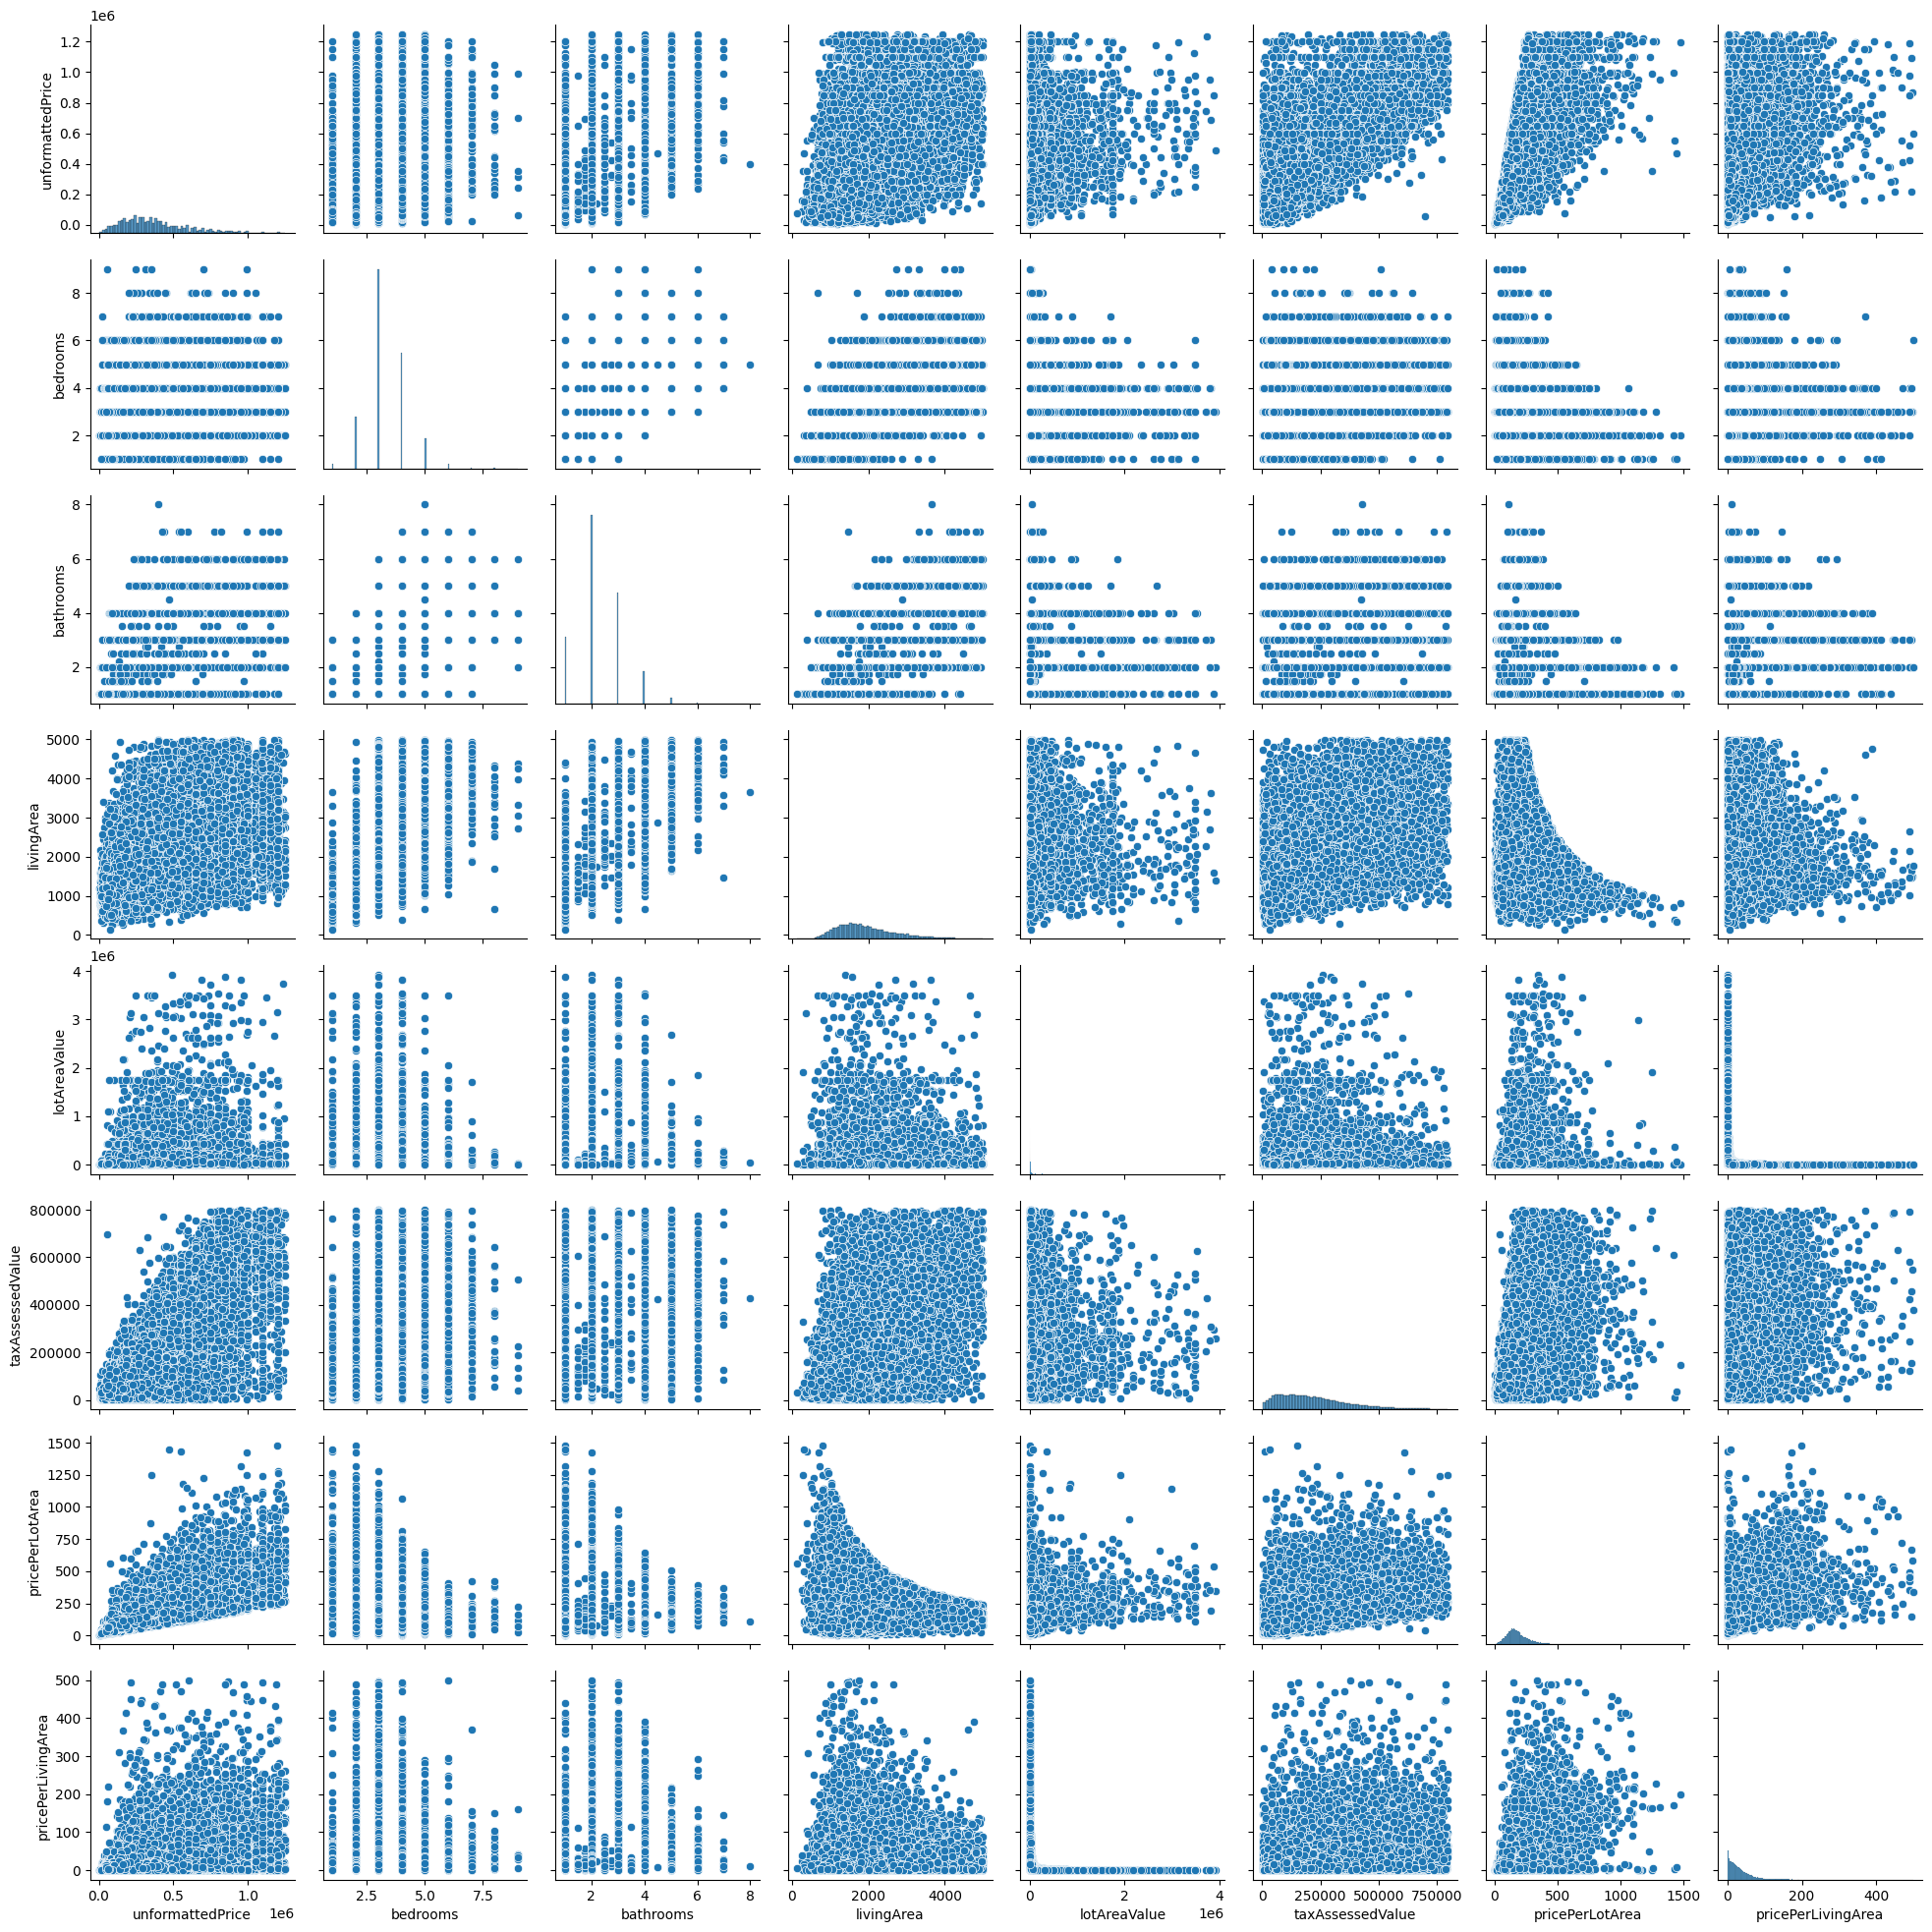

In [16]:
numeric_df = df.select_dtypes(include=['float64', 'int'])
pp = sns.pairplot(numeric_df)